# Importing Libraries

In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import simps
import matplotlib.pyplot as plt
import os
import emcee
import multiprocessing as mp
from multiprocessing import cpu_count, Pool
cores = mp.cpu_count()

# Parameters using fiducial LCDM: Planck 2015
H0_fid = 67.48                        # Hubble parameter 
h_fid = H0_fid/100                    # h 
sigma8_z = 0.6286069226243259         # Normalization Pk at z_effective
gr_z = 0.7769123846609305             # Log growth rate at z_effecitve

# Data and Files

In [16]:
# Data parameters
tapering = 500 
resampling = 200
iters_MCMC = 10
n_runs = 100
NBURN = 500

# Power spectrum from xi_0_2_power_spectrum_creator.ipynb
Pks = np.loadtxt('Matter_Power_Spectrum_z_056_Planck2015.txt')
k_class      = Pks[0]
pk_class     = Pks[1]
pk_hat_class = Pks[2]

# DATA
DATA_mono = np.loadtxt('DATA/monopole.txt').T
DATA_cuad = np.loadtxt('DATA/quadrupole.txt').T
COVA_mono = np.loadtxt('DATA/cov_matrix_monopole.txt')
COVA_cuad = np.loadtxt('DATA/cov_matrix_quadrupole.txt')
COVA_cros = np.loadtxt('DATA/cov_matrix_x2x0.txt')

# Total covariance matrix
COV_total = np.block([[COVA_mono, COVA_cros],[COVA_cros.T,COVA_cuad]])

# Useful Functions

## Correlation function $\xi(r)$

- 2D Power Spectrum: $P(k,\mu) = FG(k,\mu)\left\{1+2f\mu^2+f^2\mu^4\right\}P(k)$


- $P(k)$ from CLASS and $FG(k,\mu)=1$


- $P_k$ Multipoles: $P_l^s=\frac{2l+1}{2}\int^1_{-1}d\mu P(k,\mu)L_l(\mu)$


- $\xi$ Multipoles: $\xi_l(s)=i^l\int_0^{\infty}\frac{dk}{2\pi^2}k^2P^s_l(k)j_l(ks)$


- Monopole: $\xi_0(s)=\frac{1}{4\pi^2}\left(2+\frac{4}{3}f+\frac{2}{5}f^2\right)\int_0^{\infty}dkk^2j_0(ks)P(k)$


- Quadrupole: $\xi_2(s)=\frac{-5}{4\pi^2}\left(\frac{12}{5}f-\frac{4}{3}f+\frac{6}{7}f^2-\frac{2}{5}f^2\right)\int_0^{\infty}dkk^2j_2(ks)P(k)$


- Model $P_k$: $P(k) = \left(P_{CLASS}(k)-P_{dw}(k)\right)e^{-\frac{1}{2}(\Sigma_{NL}k)^2}+P_{dw}(k)$

In [17]:
inte_mu_0 = 2 + 4*gr_z/3 + 2*gr_z**2/5
inte_mu_2 = 0.5*(12*gr_z/5 - 4*gr_z/3 + 6*gr_z**2/7 - 2*gr_z**2/5)

def model_pk_nl(sigma,k = k_class, pk = pk_class,pk_hat = pk_hat_class):
    return (pk-pk_hat)*np.exp(-(k**2 * sigma**2)/2) + pk_hat

def inter_xi_0(r, k = k_class, pk = pk_class):
    interg = k**3 * pk * np.sin(k*r)/(k*r)
    return 1/(4*np.pi**2) * simps(interg,np.log(k*r))

def inter_xi_2(r, k = k_class, pk = pk_class):
    j2 = (3/((k*r)**2) - 1)*np.sin(k*r)/(k*r) - 3*np.cos(k*r)/((k*r)**2)
    interg = k**3 * pk * j2
    return -5/(4*np.pi**2) * simps(interg,np.log(k*r))

def xi_0(r, sigma,k = k_class, pk = pk_class,pk_hat = pk_hat_class): 
    """
    Computes the monopole function
    r given in Mpc/h 
    """
    pk_m = model_pk_nl(sigma, k = k, pk = pk, pk_hat = pk_hat)
    xi = np.array([inter_xi_0(_r/h_fid,k = k, pk = pk_m) for _r in r])
    return inte_mu_0 * xi/(sigma8_z**2)

def xi_2(r, sigma,k = k_class, pk = pk_class,pk_hat = pk_hat_class):
    """
    Computes de quadrupole function
    r given in Mpc/h 
    """
    pk_m = model_pk_nl(sigma, k = k, pk = pk, pk_hat = pk_hat)
    xi = np.array([inter_xi_2(_r/h_fid,k = k, pk = pk_m) for _r in r])
    return inte_mu_2 * xi/(sigma8_z**2)



## Tapering Function

- Method in Paz D. J., Sánchez A. G., 2015, MNRAS, 454, 4, 4326


- Tapering Matrix: $T_{ij} = K\left(|x_i-x_j|\right)$


- Kernel Function: $K(x<t_p) = \left(1-\frac{x}{t_p}\right)^4\left(4\frac{x}{t_p}+1\right)$,   $K(x>t_p)=0$

In [18]:
def tapper_function(x,Tp):
    if x<Tp: return (1-x/Tp)**4 *(4*x/Tp +1)
    else: return 0

def tapper_matrix(data_ind, Tp):
    n = len(data_ind)
    TAPPER_MATRIX = np.zeros([n,n])
    for i in range(0,n):
        for j in range(0,n):
            dist = abs(data_ind[j]-data_ind[i])
            TAPPER_MATRIX[i,j] = tapper_function(dist,Tp)
    return TAPPER_MATRIX

# Presicion Matrix: $\hat{\Psi}$

- $\hat{C}$: Covariance Matrix


- $T$: Tapering Matrix


- $\hat{\Psi} = \left(1-\frac{n_{\rm{b}}+1}{N_{\rm{res}}-1}\right)\left(\hat{C}\circ T\right)^{-1}\circ T$

Text(0.5, 1.0, 'Tapering Matrix')

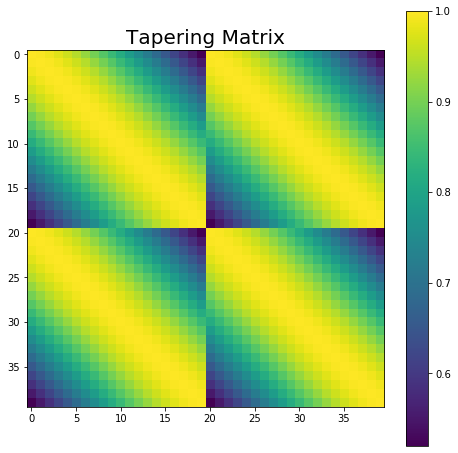

In [19]:
hartlap_factor = 1-(len(DATA_mono[0])+1)/(resampling-1)

DATA_pos = np.concatenate((DATA_mono[0],DATA_cuad[0]))
DATA_xis = np.concatenate((DATA_mono[1],DATA_cuad[1]))

tap_m = tapper_matrix(DATA_pos,tapering)
pres_ = np.linalg.inv(COV_total*tap_m)*tap_m*hartlap_factor

plt.figure(figsize=[8,8])
plt.imshow(tap_m)
plt.colorbar()
plt.title(r'Tapering Matrix',size=20)

# MCMC Algorithm

## Priors 

- Flat priors for all parameters

In [20]:
p1i, p1f = [     0.0,  10.0] # Bs
p2i, p2f = [     0.7,   1.3] # alpha
p3i, p3f = [   -10.0,  10.0] # a0s
p4i, p4f = [  -500.0, 500.0] # a1s
p5i, p5f = [ -1000.0,1000.0] # a2s
p6i, p6f = [     0.0,  30.0] # sigma_nl

## Posteriori, Likelihood and Prior functions

- $\chi^2 = \left(\vec{\xi}-\vec{d}\right)^T\hat{\Psi}\left(\vec{\xi}-\vec{d}\right)$


- model: $\xi_i= B_i\xi_{th}^{(i)}(\alpha r,\Sigma_{NL})+a^{(i)}_0+\frac{a^{(i)}_1}{r}+\frac{a^{(i)}_2}{r^2}$


- $\ln \mathcal{L}(data|\theta)\propto-\frac{1}{2}\chi^2$


- $\ln P(\theta|data) = \ln \mathcal{L}(data|\theta) + \ln p(\theta)$

In [21]:
def lnlike_s(theta):
    x, y, pres = DATA_mono[0], DATA_xis, pres_
    B1, B2, alpha, a0, a1, a2, a02, a12, a22, sigma = theta
    
    model0 = B1 * xi_0(alpha*x,sigma) + a0 + (a1/x) + (a2/(x**2))
    model2 = B2 * xi_2(alpha*x,sigma) + a02 + (a12/x) + (a22/(x**2))
    model  = np.concatenate((model0,model2))
    chi2   = -0.5*np.dot((model-y).T,np.dot(pres,(model-y)))
    
    return chi2

def lnprior_s(theta):
    B1, B2, alpha, a0, a1, a2, a02, a12, a22, sigma = theta
    cond1 = p1i < B1 < p1f and p1i < B2 < p1f
    cond2 = p3i < a0  < p3f and p4i < a1  < p4f and p5i < a2  < p5f
    cond3 = p3i < a02 < p3f and p4i < a12 < p4f and p5i < a22 < p5f
    cond4 = p2i < alpha < p2f and p6i < sigma < p6f
    if cond1 and cond2 and cond3 and cond4:
        return 0
    return -np.inf

def lnprob_s(theta):
    lp = lnprior_s(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_s(theta)

## MCMC Chains

In [22]:
start_point = [2.19, 1.0, 0.98, -0.001, 0.5, -33, -0.001, 0.5, -33, 15.4]

ndim, nwalkers = len(start_point), n_runs
seed = np.random.seed(51294)
pos = start_point + 1e-3*np.random.randn(nwalkers, ndim)


with Pool(cores) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_s,pool=pool)
    sampler.run_mcmc(pos, iters_MCMC, progress=True, rstate0=seed)

100%|██████████| 10/10 [04:15<00:00, 25.59s/it]


## Save the chains

- Save the parameters and the $\chi^2$

In [23]:
run_iters = iters_MCMC    
CHAIN_total = np.zeros([n_runs,iters_MCMC,ndim+1])
min_value = 10000
ind_i, ind_j = [0,0]
for i in range(0,nwalkers):
    for j in range(0,run_iters):
        for k in range(0,ndim+1):
            if k==ndim:
                chi2_s = sampler.get_log_prob()[j,i]/-0.5
                CHAIN_total[i,j,k] = chi2_s
                if chi2_s <min_value:
                    min_value = chi2_s
                    ind_i, ind_j = [i,j]
            else: CHAIN_total[i,j,k] = sampler.chain[i,j,k]
                
chi2_min_mcmc = min_value
all_samples = CHAIN_total.reshape((-1, ndim+1))

id_1 = str(iters_MCMC)+'x'+str(n_runs)
id_2 = '_tp_'+str(tapering)+'_res_'+str(resampling)
id_chain = id_1+id_2
my_chain = 'xi_0_2_mcmc_chain_'+id_chain+'.txt'

if not os.path.exists(my_chain):
    np.savetxt(my_chain,all_samples)
else:
    num = 1
    while os.path.exists(my_chain):
        my_chain = 'xi_0_2_mcmc_chain_'+id_chain+'_'+str(num)+'.txt'
        num += 1
    np.savetxt(my_chain,all_samples)